##**BIO/QTM 385: In class exercise for Monday, November 22nd** 


(answers will be the part of Assignment #6, Due 12/1)

<font color='green'>**Enter your names and group number here.**  </font>

*This notebook contains modified excerpts from the [Hands-One Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurelien Geron; the content is available [on GitHub](https://github.com/ageron/handson-ml2). The code is released under the [Apache-2.0 License](https://github.com/ageron/handson-ml2/blob/master/LICENSE).*

As always, all questions to be answered will be in <font color="blue"> blue</font> and places to write your answers will be in <font color="green"> green</font>.

To start, make sure that you go up to the **Runtime** menu, and make sure that *Hardware Accelerator* is set to *GPU* (otherwise your code will take forever to run)

In [ ]:
!nvidia-smi;

import numpy as np
import os
import numpy.random as random
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.layers as layers
import keras.models as models
from keras.layers import Dense, Input, Flatten, Reshape, Dropout
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
K = keras.backend
import multiprocessing as mp
from joblib import Parallel, delayed

In [ ]:
# @title Helper Functions & Figure Settings

import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=( n_rows,n_cols))
    for index, image in enumerate(images):
        plt.subplot(n_cols, n_rows,index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(15):
    for k2 in range(15):
      k = k + 1
      plt.imshow(X[k],
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255,cmap='gray')
  plt.xlim((15 * 28, 0))
  plt.ylim((15 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 255])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_training_history(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['loss'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")    
    if 'val_accuracy' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['accuracy'], '--', label='Training Accuracy', color='firebrick', )
        ax2.plot(hist.history['val_accuracy'], '--', label='Testing Accuracy', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("accuracy")

def plot_training_history(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['loss'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")    
    if 'val_accuracy' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['accuracy'], '--', label='Training Accuracy', color='firebrick', )
        ax2.plot(hist.history['val_accuracy'], '--', label='Testing Accuracy', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("accuracy")



def make_fashion_mnist_plot(X_valid_2D,X_valid,y_valid):
  # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
  cmap = plt.cm.tab10
  x = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
  plt.scatter(x[:, 0], x[:, 1], c=y_valid, s=10, cmap=cmap)
  image_positions = np.array([[1., 1.]])
  for index, position in enumerate(x):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
  plt.axis("off")
  plt.show()


def show_reconstructions(model, images, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


def plot_training_history(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['loss'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")    
    if 'val_accuracy' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['accuracy'], '--', label='Training Accuracy', color='firebrick', )
        ax2.plot(hist.history['val_accuracy'], '--', label='Testing Accuracy', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("accuracy")


def plot_training_history_last_step(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['last_time_step_mse'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_last_time_step_mse'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")    
    if 'val_accuracy' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['accuracy'], '--', label='Training Accuracy', color='firebrick', )
        ax2.plot(hist.history['val_accuracy'], '--', label='Testing Accuracy', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("accuracy")



def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


##Recurrent Neural Networks

###Introduction
For many problems, context matters.  Tommorrow's stock market returns are likely to be correlated with today's.  The future trajectory of a spinning baseball depends on the linear and angular momentum imparted to it by a pitcher.  When trying to predict the next note in a piece of music, the answer is highly dependent on the notes that came before and the scale/mode in which the piece is written.  Sentence, this no sense makes (to paraphrase Yoda - or to literally translate from German to English).

So far, however, our modeling efforts have largely focused on trying to understand data that are *statistically stationary*.  In other words, the order doesn't matter.  For instance, it didn't matter that the order we fed MNIST or Fashion MNIST data into our autoencoders - the results would be (mostly) the same if we completely shuffled the order of the input data.  So how can we model these types of systems where the order matters?  

The idea is to turn sequences of data into a deep neural network that unfolds through time.  This network is called a Recurrent Neural Network and it is illustrated below.



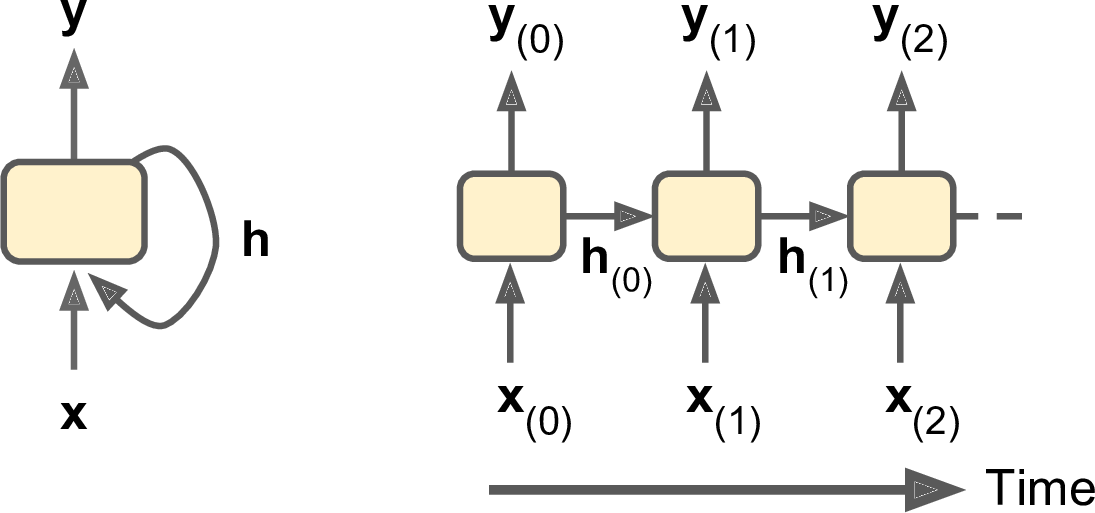

On the left, we have an input, $x$ (which could be either a vector or a scalar), that is fed through a hidden layer, $h$, to result in an output, $y$ (which could also be either a vector or a scaler).  This is the same as our standard deep neural network.  The difference, however, is that we will allow the hidden layer to change with time, updating its weights at each time step.  More practically, we can think of this network as a neural network that is moving in time.  Each new $x_{(t)}$ feeds in $h_{(t-1)}$, which, in turn, is read-out into $y_{(t)}$. $h_{(t-1)}$ then updates to $h_{(t)}$, and the process continues.

Mathematically, a simple example of these updates might look like:
\begin{eqnarray}
y_{(t)} &=& \phi\left[W^{(x)}x_{(t)} + W^{(y)}h_{(t-1)} + b^{(y)}\right]\\
h_{(t)} &=& \phi\left[W^{(h)}h_{(t-1)} + b^{(h)} \right],\\
\end{eqnarray}
where $\phi(x)$ is an activation function (e.g., a sigmoid).  Naturally, these networks can be made more complicated in a variety of ways (we will see several!), but the essential idea is the same: input sequential data into a neural network and change the mapping between input and output based on changes in the hidden state.  The weights of the network are still trained via backpropagation, but now instead of just through layers, the backpropagation is also through time.

###A made-up example

To see how we can train RNNs in keras, we will start by getting the network to learn the dynamics of a generic set of functions using the ```generate_time_series()``` function below: 

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

This function will return ```batch_size``` examples of the function
\begin{equation}
f(t) = \frac{1}{2}\sin\left[(10f_1+10)(t-o_1) \right] + \frac{1}{5}\sin\left[(20f_2+20)(t-o_2) \right] + \eta(t)
\end{equation}
for $t$ evenly spaced between 0 and 1.  Here, $f_1$, $f_2$, $o_1$, and $o_2$ are all randomly chosen from $[0,1]$ for each example, and $\eta(t)$ is Gaussian noise from $\mathcal{N}(0,1)$.  A few examples are plotted below.

In [ ]:
n_steps = 50
batch_size = 3
data = generate_time_series(batch_size, n_steps+1)

fig, axes = plt.subplots(nrows=1, ncols=batch_size, sharey=True, figsize=(14, 5))
for col in range(batch_size):
    plt.sca(axes[col])
    plot_series(data[col, :, 0], data[col,-1, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

print(np.shape(data))

Note that the shape of the output matrix, ```data```, is a 3-d ```numpy``` array, with the last dimension having a length of 1.  If the input data is a vector, then the last dimension becomes has the same length as the input (e.g., if the time size was a 3-d vector, the shape might be ```(3,51,3)```).

Given these time series, let's generate a training, test, and validation set (10,000 examples in total - 7,000 in the training set, 2,000 in the test, and 1,000 in the validation).  Here, our ```X``` values are the first 50 values of each example, and the ```y``` values are the last value of the example (note the shapes of the various arrays).

In [ ]:
n_steps = 50
batch_size = 10000
training_size = 7000
valid_size = 2000

data = generate_time_series(batch_size, n_steps + 1)
X_train, y_train = data[:training_size, :n_steps], data[:training_size, -1]
X_valid, y_valid = data[training_size:(training_size+valid_size), :n_steps], data[training_size:(training_size+valid_size), -1]
X_test, y_test = data[(training_size+valid_size):, :n_steps], data[(training_size+valid_size):, -1]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

Given these data sets, let's construct a vanilla RNN (i.e., we'll use simple cell types for the hidden layer) that tries to predict the last data point from the first 50.  We'll start by building the simplest RNN we can think of - a single hidden layer with one neuron (the image on the left in the cartoon above).  Note that the ```SimpleRNN``` layer uses a $\tanh$ activation function by default.



In [ ]:
#define a single layer RNN
simple_model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

#define an 'adam' optimizer with a learning rate of .005
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

#compile and train the RNN for 10 epochs
simple_model.compile(loss="mse", optimizer=optimizer)
history = simple_model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),batch_size=128)

plot_training_history(history)

We can generate predictions from our model, once again using ```model.predict()```.

In [ ]:
y_pred = simple_model.predict(X_valid)
print(np.shape(y_pred))

Now let's plot the results for a few examples!  The curves below are showing three random examples from the time series.  The blue "x" is the actual value, and the red dot is the model's prediction.

In [ ]:
n_examples = 3

q = random.choice(np.arange(0,2000),3)
fig, axes = plt.subplots(nrows=1, ncols=n_examples, sharey=True, figsize=(14, 5))
for col in range(n_examples):
    plt.sca(axes[col])
    plot_series(X_valid[q[col], :, 0], y_valid[q[col], 0],y_pred[q[col],0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

These don't exactly look great, do they?  We can quantify the error via the mean-squared-error.

In [ ]:
simple_model.evaluate(X_valid, y_valid)

<font color=blue> **Question #1**: One baseline metric for computing whether fitting an RNN is "worth" it is to compare it to a very simple model: predicting that $x_{(t)} = x_{(t-1)}$.  Calculate and compare the mean-squared-error between this model to the error you got from the RNN.  How did the RNN do in comparison?

In [ ]:
#Type your code to Question #1 here

<font color=green> Compare the mean-squared-error between this model to the error you got from the RNN.  How did the RNN do in comparison?

<font color=blue> **Question #2**: Another baseline metric for computing whether fitting an RNN is "worth" it is to compare it to a feedfoward neural network with a single dense layer of 1 neuron (linear activation functions).  This is really just a linear regression!  Code and train this network, and compare your mean-squared-error to the RNN and your answer to Question #1.

In [ ]:
#Type your code to Question #2 here

<font color=green> Compare your mean-squared-error to the RNN and your answer to Question #1.

<font color=blue> **Question #3**: Since our very simple RNN wasn't particularly successful, let's try something a bit different - make a single layer RNN with 50 hidden units instead of just one.  Compare your results to the simpler RNN and you answer to Question #2.  Have you beaten the linear model?

In [ ]:
#Type your code for Question #3 here

<font color=green> Compare your results to the simpler RNN and you answer to Question #2.  Have you beaten the linear model? </font>

Similar to other neural network models we've seen so far, RNNs often can achieve better performance by stacking multiple hidden layers, as illustrated in the image below:

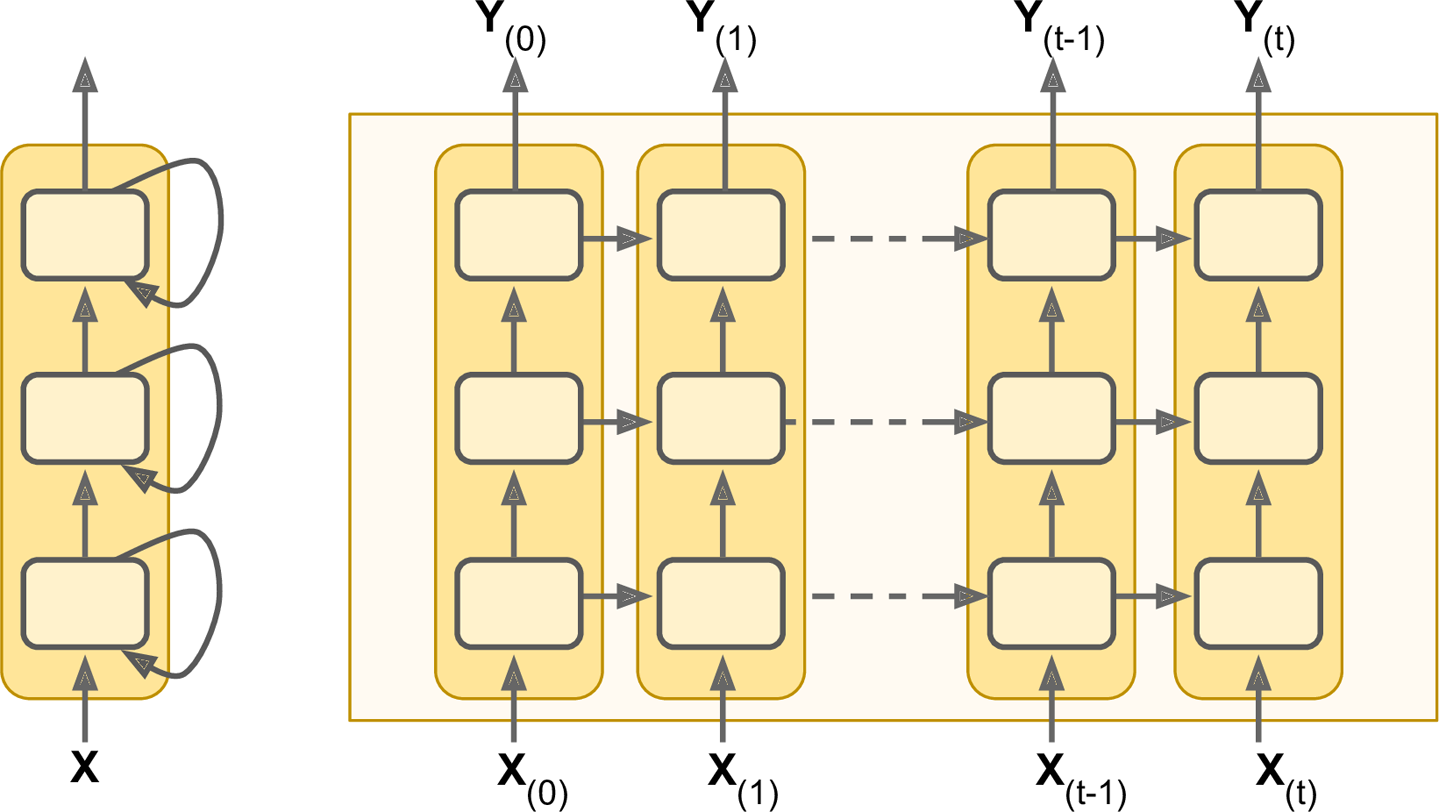

Like in the simple example we built previously, this can be seen as a transformation between an input, $X_{(t)}$ and an output, $Y_{(t)}$, but with the intermediate layers changing in time - altering the nature of the transformation.

Fortunately, implementing such a network is relatively straight-forward in keras (it's rather similar to the autoencoder models we've built previously).  The following shows an example of a three layer RNN, with the first two layers having 20 units each, and the last layer having a single unit.

In [ ]:
#implement the deep RNN
model_deep = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

#compile the deep RNN
model_deep.compile(loss="mse", optimizer="adam")
history_deep = model_deep.fit(X_train, y_train, epochs=20,batch_size=256,
                    validation_data=(X_valid, y_valid))

plot_training_history(history_deep)

In [ ]:
n_examples = 3

y_pred_deep = model_deep.predict(X_valid)

q = random.choice(np.arange(0,2000),3)
fig, axes = plt.subplots(nrows=1, ncols=n_examples, sharey=True, figsize=(14, 5))
for col in range(n_examples):
    plt.sca(axes[col])
    plot_series(X_valid[q[col], :, 0], y_valid[q[col], 0],y_pred_deep[q[col],0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()


model_deep.evaluate(X_valid,y_valid)

Finally -- we've beaten the linear regression model!  (Or at least we should have...)

As a note, because ```SimpleRNN``` uses a $\tanh$ activation function, if you want to have an output that is not between -1 and 1 (these curves are almost always between these values by construction!), you can replace the last ```SimpleRNN``` layer with a ```Dense``` layer (and you can pick whatever activation function you want.

###Forecasting Time Series

Up to this point, we've only been interested in finding the next value in a time series.  Typically, though, we're usually interested in predicting multiple points into the future.  We can achieve this by simply changing our ```y``` values for our training / test / validation sets to be vectors instead of scalars.  Using the same "data" as we've used before, we can now generate data where we record 50 data points, then we want to predict the next 10 data points.

In [ ]:
n_steps = 50
steps_ahead = 10

series = generate_time_series(10000, n_steps + steps_ahead)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -steps_ahead:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -steps_ahead:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -steps_ahead:, 0]

print(np.shape(X_train),np.shape(Y_train))
print(np.shape(X_valid),np.shape(Y_valid))
print(np.shape(X_test),np.shape(Y_test))

We can now build a deep RNN with the same structure as before, but now, we need to have ```steps_ahead``` units in the output layer.

In [ ]:
model_forecast = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(steps_ahead)
])

model_forecast.compile(loss="mse", optimizer="adam")
history_forecast = model_forecast.fit(X_train, Y_train, epochs=20,batch_size=256,
                    validation_data=(X_valid, Y_valid))

plot_training_history(history_forecast)

In [ ]:
model_forecast.evaluate(X_valid,Y_valid)

Now let's generate a few brand new series and see how well our model does at predicting the future.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=n_examples, sharey=True, figsize=(16, 10))
for i in range(6):
  
  plt.subplot(2,3,i+1)

  new_series = generate_time_series(1, n_steps + steps_ahead)
  X_new, Y_new = new_series[:, :n_steps, :], new_series[:, -steps_ahead:, :]
  Y_pred = model_forecast.predict(X_new)[..., np.newaxis]

  plot_multiple_forecasts(X_new, Y_new, Y_pred)

plt.show()

<font color = blue> **Question #4**: Now try building a network that predicts the next 50 time steps (starting from 50 data points, again).  Plot a few examples (like shown above).  Describe what happens as the points move further away from the original 50 points.

In [ ]:
#Type your answer to Question #4 here

<font color= green> Describe what happens as the points move further away from the original 50 points.

###Forecasting with a Sequence-to-Sequence network

This method works reasonably well, but we can do better!  The previous model is effectively a *sequence-to-vector* model, meaning that a sequence is input, and a 10-dimensional (or 50-dimensional in the Question #4) vector is the output.  We often can get better performance, however, if we instead use a *sequence-to-sequence* model.  In this type of model, we input, say, $\{x_{(1)},\ldots,x_{(50)}\}$, but our output is now, say, $\{x_{(11)},\ldots,x_{(60)}\}$ (instead of $\{x_{(51)},\ldots,x_{(50)}\}$).  This type of training often leads to more robust model performance, as it is harder to over-fit.

To turn our previous model into a sequence-to-sequence model, we must set ```return_sequences=True``` in all recurrent layers (even the last one), and we must apply the output ```Dense``` layer at every time step. Keras offers a ```TimeDistributed``` layer for this very purpose: it wraps any layer (e.g., a Dense layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance (i.e., it reshapes the inputs from ```[batch size, time steps, input dimensions]``` to ```[batch size × time steps, input dimensions]```; in this example, the number of input dimensions is 20 because the previous ```SimpleRNN``` layer has 20 units), then it runs the ```Dense``` layer, and finally it reshapes the outputs back to sequences (i.e., it reshapes the outputs from ```[batch size × time steps, output dimensions]``` to ```[batch size, time steps, output dimensions]```; in this example the number of output dimensions is 10, since the ```Dense``` layer has 10 units).

In [ ]:
n_steps = 50
steps_ahead = 10

series = generate_time_series(10000, n_steps + steps_ahead)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -steps_ahead:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -steps_ahead:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -steps_ahead:, 0]

#re-define the training and test set
Y = np.empty((10000, n_steps, steps_ahead)) # each target is a sequence of 10D vectors
for step_ahead in range(1, steps_ahead + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

print(np.shape(X_train),np.shape(Y_train))
print(np.shape(X_valid),np.shape(Y_valid))
print(np.shape(X_test),np.shape(Y_test))


Note how now the ```Y``` values are now also sequences of length 50.

In [ ]:
#define a mean-squared-error metric that only focuses on the last time step (to better comapre to the previous methods)
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
#define the model
model_seq_to_seq = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_seq_to_seq.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history_seq_to_seq = model_seq_to_seq.fit(X_train, Y_train, epochs=25,batch_size=128,
                    validation_data=(X_valid, Y_valid))

plot_training_history(history_seq_to_seq)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=n_examples, sharey=True, figsize=(14, 10))
for i in range(6):
  
  plt.subplot(2,3,i+1)

  new_series = generate_time_series(1, n_steps + steps_ahead)
  X_new, Y_new = new_series[:, :n_steps, :], new_series[:, -steps_ahead:, :]
  Y_pred = model_seq_to_seq.predict(X_new)[..., np.newaxis]

  plot_multiple_forecasts(X_new, Y_new, Y_pred[:,-1,:,:])

plt.show()

<font color=blue> **Question #5**: Create antother *sequence-to-sequence* RNN, but now trying to predict 50 future steps.  Plot a few examples.  Compare these results to your results from Question #4.

In [ ]:
#Type your code for Question #5 here

<font color=green> Compare these results to your results from Question #4.

###LSTM and GRU cells

Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) cells (as discussed in class) are often much better at predicting long time series than a vanilla RNN (i.e., ```SimpleRNN```).  To implement these cells, you simply need to replace ```SimpleRNN``` with either ```LSTM``` or ```GRU``` when defining your model.

<font color=blue> **Question #6** Repeat Question #5, but using LSTM cells for the first two recurrent layers.  Compare these results to your results from Questions #4 & #5.

In [ ]:
#Type your code for Question #6 here

<font color=green> Compare these results to your results from Questions #4 & #5.

<font color=blue> **Question #7** Repeat Question #5, but using GRU cells for the first two recurrent layers.  Compare these results to your results from Questions #4, #5, & #6.

In [ ]:
#Type your code for Question #7 here


<font color=green> Compare these results to your results from Questions #4, #5, & #6.

###Imputation

We've mainly discussed *prediction* (predicting the next time points in a sequence) so far, but another useful applicaiton of RNNs is *imputation* (filling in missing data points).  We can achieve this by using *bidirectional* RNNs, as illustrated below.

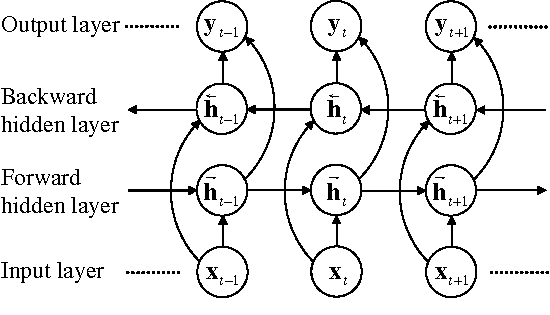

Essentially, we have two hidden layers, each moving in the opposite direction from each other.  This structure can allow us to fill-in holes in the data.  Like with the other things we've learned about today, keras has a relatively easy implementation of bidirectional RNNs through the ```Bidirectional``` layer API.

We can especially train the network to look for such structure by training it with ```Dropout``` feeding into the network.  This allows the network to learn the underlying structure when individual points are missing (like using ```Dropout``` in denoising autoencoders).  Here, we use ```p=0.1``` for the ```Dropout```. 

In [ ]:
n_steps = 50
steps_ahead = 1
dropout_rate = .1

series = generate_time_series(10000, n_steps + steps_ahead)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -steps_ahead:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -steps_ahead:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -steps_ahead:, 0]

#re-define the training and test set
Y = np.empty((10000, n_steps, steps_ahead)) # each target is a sequence of 10D vectors
for step_ahead in range(1, steps_ahead + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

model_bidirectional = keras.models.Sequential([
    keras.layers.Dropout(dropout_rate),                                            
    keras.layers.Bidirectional(keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1])),                     
    keras.layers.Bidirectional(keras.layers.GRU(20, return_sequences=True)),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_bidirectional.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history_bidirectional = model_bidirectional.fit(X_train, Y_train, epochs=20,batch_size=256,
                    validation_data=(X_valid, Y_valid))

plot_training_history_last_step(history_bidirectional)

From here, we can plot the actual missing point (magenta 'X') and the imputed point (the red circle) for 4 newly-generated data sets.

In [ ]:
#remove the points 20 and 21 from the data set
remove_idx = np.arange(20,22)

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14, 5))
for i in range(4):

  plt.subplot(1,4,i+1)

  #generate a new time series
  new_series = generate_time_series(1, n_steps + steps_ahead)

  #save and delete the actual value for point #20
  saved_values = np.copy(new_series[0,remove_idx,0])
  new_series[0,remove_idx,0] = 0

  #predict the new values
  y_pred = model_bidirectional.predict(new_series)

  #return the predicted value for point #20 (note that this is shifted by one)
  corrected_values = y_pred[0,remove_idx-1,0]

  #plot the data

  idx = np.setdiff1d(np.arange(0,n_steps),remove_idx)
  plt.plot(np.arange(0,remove_idx[0]),new_series[0,0:remove_idx[0],0],'-bo')
  plt.plot(np.arange(remove_idx[-1],n_steps),new_series[0,remove_idx[-1]:n_steps,0],'-bo')
  plt.plot(remove_idx,saved_values,'mx',markersize=12)
  plt.plot(remove_idx,corrected_values,'ro',markersize=12)

plt.show()

<font color = blue> **Question #8**: Calculate and plot the mean-squared error for predicted points from your Bidirectional network, averaging over 50 newly-generated time series, each with gaps of length $k=2, 4, 6, \ldots, 20$ (you can use the code above, but with the plotting eliminated).  In other words, generate 50 new time series, take out $k$ time points from each, impute the points in the gap, and calculate the mean-squared error.  Keep the gap near the middle of the sequence, and remember that you will need to divide your value by the length of the gap, since you are predicting more points for longer gaps.

In [ ]:
#Type your code for Question #8 here

<font color=blue> **Question #9**: Now re-do Question #8, but re-training the network above with a Dropout probability of ```p=0.5```.  Has this improved, degraded, or had no appreciable effect on your imputation quality compared to ```p=0.1```?  Discuss why this might be.

In [ ]:
#Type your code for Question #9 here

<font color=green> Has this improved, degraded, or had no appreciable effect on your imputation quality compared to ```p=0.1```?  Discuss why this might be.